# M3: Targeted to Global Conversion

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# import os ; replaced below
from pathlib import Path

In [6]:
# consider simplifying to assume input files and if not found, create
# modify to match SEARCH_MSG_OUT with save path behavior

SEARCH_MSG_IN = \
    f"> Select a folder to add it to the path and search inside.\n" \
    f"> Select a file to finish the search process.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit\n" \
    f"[U] Search up one level"

def findFile(input_path):
    current_path = Path(input_path)
    if not current_path.exists(): return(f"Invalid Path: {current_path}")

    print(f"Current path: {current_path}")
    print(SEARCH_MSG_IN)

    file_list = [f for f in current_path.iterdir()]
    print("--- Files in current folder:")
    for id, file_path in enumerate(file_list):
        print(f"[{id}] {file_path.name}")
    print("")

    choice = input().lower()
    while choice not in ["u", "e"] + [str(i) for i in range(len(file_list))]:
        choice = input("Couldn't read input, trying again. Target #: ").lower()

    if choice == "e": return("Exiting.")
    if choice == "u": return(findFile(current_path.parent))
    if choice.isnumeric() and int(choice) in range(len(file_list)):
        current_path = current_path / file_list[int(choice)]
        if current_path.is_dir(): return(findFile(current_path))
        elif current_path.is_file(): return current_path

    return("Error reading path, exiting.")

In [12]:
data_path = findFile(Path.cwd())
print(f"Path selected: {data_path}")

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/scripts
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
--- Files in current folder:
[0] su25 script.ipynb
[1] wi25 lab data script.ipynb
[2] wi25 lab data script.py

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
--- Files in current folder:
[0] .DS_Store
[1] input files
[2] README.md
[3] m3venv
[4] .gitignore
[5] output files
[6] scripts
[7] .git

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/input files
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level

In [13]:
df = pd.read_csv(data_path).dropna()

In [14]:
df.head()

,Wavelength (µm),Augite ws592 spliced
0,0.3011,0.045344
1,0.3051,0.047974
2,0.3091,0.049266
3,0.3131,0.054325
4,0.3171,0.058099


In [15]:
df.describe()

,Wavelength (µm),Augite ws592 spliced
count,1967.000000,1967.000000
mean,2.275941,0.363054
std,0.895307,0.106388
min,0.301100,0.045344
25%,1.870520,0.298872
50%,2.273750,0.377143
75%,2.898600,0.438936
max,3.997030,0.557762


In [16]:
# process:
# change step size if past a breakpoint
# format:
# current wl, step to transition to
breakpoints = {
    "wl"   : [0, 0.44, 0.68, 0.71, 1.53, 1.56, 1.60], # 9999],
    "step" : [0,    4,    4,    3,    2,    3,    4]  #    4]
}

WL_COL = -1
REFL_COL = -1

try:
    if len(df.columns) < 2: raise ValueError(f"{len(df.columns)} of minimum 2 columns found")

    print(f"[#] column name")
    for i in range(len(df.columns)):
        print(f"[{i+1}] {df.columns[i]}")
except Exception as e:
    print(f"> Insufficient columns, {e}")


try:
    ans = input('Select wavelength column #')
    WL_COL = int(ans)-1
    if WL_COL not in range(len(df.columns)):
        raise ValueError(f"{ans} out of column range")
    else:
        print(f"> Selected [{ans}] {df.columns[WL_COL]} for wavelength column")
except Exception as e:
    print(f"> Unrecognized #, {e}")


try:
    ans = input('Select reflectance column #')
    REFL_COL = int(ans)-1
    if REFL_COL not in range(len(df.columns)):
        raise ValueError(f"{ans} out of column range")
    else:
        print(f"> Selected [{ans}] {df.columns[REFL_COL]} for reflectance column")
except Exception as e:
    print(f"> Unrecognized #, {e}")


try:
    wavelengths = np.array(df[df.columns[WL_COL]])
except:
    print(f"wavelength column not found")

wl_nans = np.isnan(wavelengths).sum()
if wl_nans > 0:
    print(f"wl shape: {wavelengths.shape}")
    print(f"wavelength nans: {np.isnan(wavelengths).sum()}")
    print(f"wavelength nan indices: {np.where(np.isnan(wavelengths))[0]}")


try:
    reflectance = np.array(df[df.columns[REFL_COL]])
except:
    print(f"reflectance column not found")

reflectance_nans = np.isnan(reflectance).sum()
if reflectance_nans > 0:
    print(f"reflectance shape: {reflectance.shape}")
    print(f"reflectance nans: {np.isnan(reflectance).sum()}")
    print(f"reflectance nan indices: {np.where(np.isnan(reflectance))[0]}")

[#] column name
[1] Wavelength (µm)
[2] Augite ws592 spliced
> Selected [1] Wavelength (µm) for wavelength column
> Selected [2] Augite ws592 spliced for reflectance column


In [17]:
def targeted_to_global(wavelengths, values, verbose = False):
    # average 4 at a time
    # set step size to last breakpoint
    # increment by step size
    # round to 4 decimals

    WIDTH = 7
    if verbose: print(f"{'wl':>{WIDTH}}: step, index change")

    i = 0 # input index
    bp_idx = 0
    output = {"wavelengths": [], "values": []}
    while i+3 < len(wavelengths):
        # average over next 4
        avg_wl = np.round(np.mean(wavelengths[i:i+4]),4)
        avg_values = np.round(np.mean(values[i:i+4]),4)

        # if next step exists
        # and current wl > bp_idx wl
        while bp_idx + 1 < len(breakpoints["step"]) and wavelengths[i] > breakpoints["wl"][bp_idx]:
            bp_idx += 1
            if verbose: print(f"{wavelengths[i]:{WIDTH}.{WIDTH-2}f}: {breakpoints['step'][bp_idx-1]}->{breakpoints['step'][bp_idx]}, {bp_idx-1}->{bp_idx}")

        # save and increment by values consumed
        output["wavelengths"].append(avg_wl)
        output["values"].append(avg_values)
        i += breakpoints["step"][bp_idx]
    
    output["wavelengths"] = np.array(output["wavelengths"])
    output["values"] = np.array(output["values"])
    return output

In [ ]:
### inconsistencies
## round up, not truncating
# mean(0.99497, 1.005, 1.0149, 1.0249) = 1.0099425 -> 1.0099, manual is 1.01 > 1.0099
## round down
# mean(2.3624, 2.3724, 2.3823, 2.3923) = 2.37735 -> 2.3774, manual is 2.3773 < 2.3774

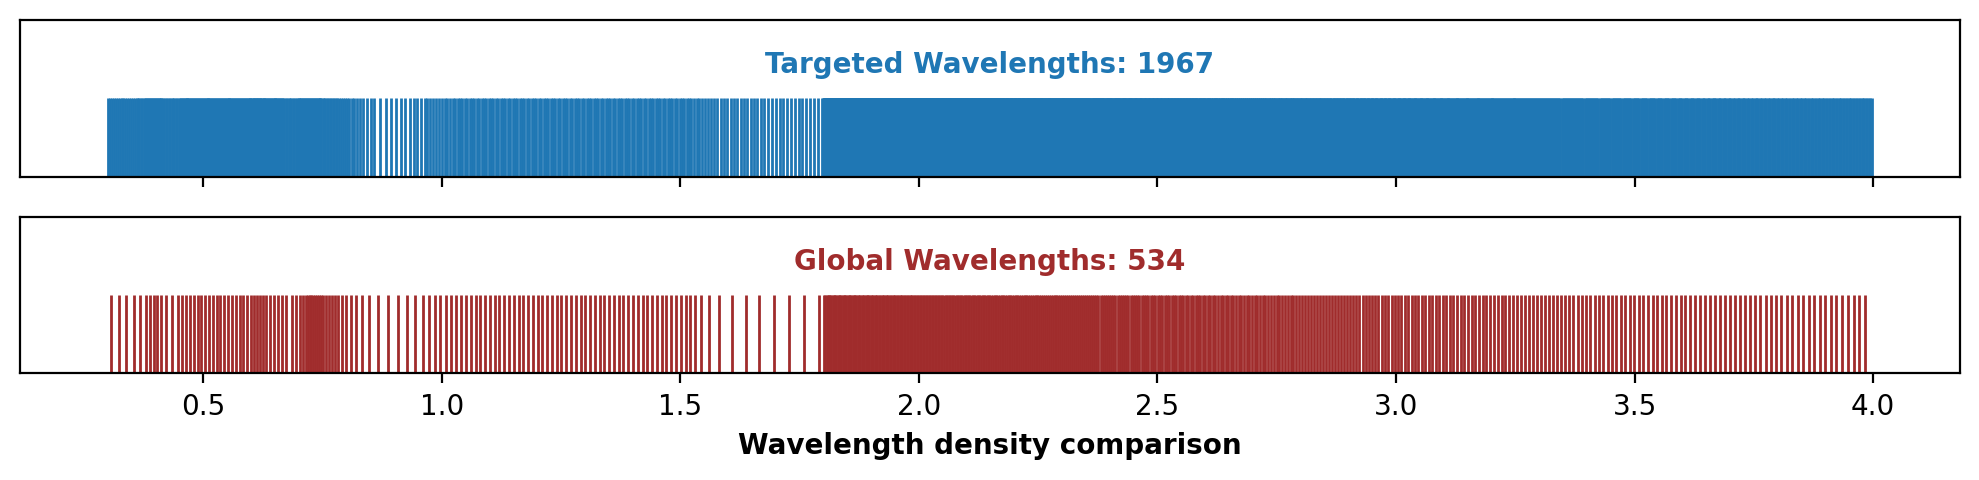

In [18]:
plotting = True
saving = False
if plotting:

    data = {
        "Targeted Wavelengths": wavelengths, 
        "Global Wavelengths": targeted_to_global(wavelengths, reflectance)["wavelengths"]
    }

    colors = ['#1f77b4', "#a02c2c"]
    fig, axes = plt.subplots(
        nrows=2,
        sharex=True, 
        figsize=(10, 2.5), 
        height_ratios=[1, 1]
    )

    # each series as a rug plot with its own row
    for ax, (label, series), color in zip(axes, data.items(), colors):
        sns.rugplot(x = series, ax = ax, height = 0.5, color = color)
        ax.set_yticks([])  # No y-axis ticks
        ax.set_ylabel("")
        ax.text(
            0.5, # x offset
            0.8, # y offset
            f"{label}: {series.shape[0]}", # text content
            # **kwargs
            transform=ax.transAxes, 
            ha='center', 
            va='top', 
            fontsize=10, 
            color=color, 
            weight='bold'
        )

    # last plot label acts as legend label
    axes[-1].set_xlabel("Wavelength density comparison", weight = 'bold') 
    plt.tight_layout()

    if saving:
        plt.savefig(
            "../output files/graphs/test/m3 wavelength comparison.png", 
            dpi=2000, 
            bbox_inches='tight',
            facecolor='white'
        )

    plt.show() # calls plt.clf()

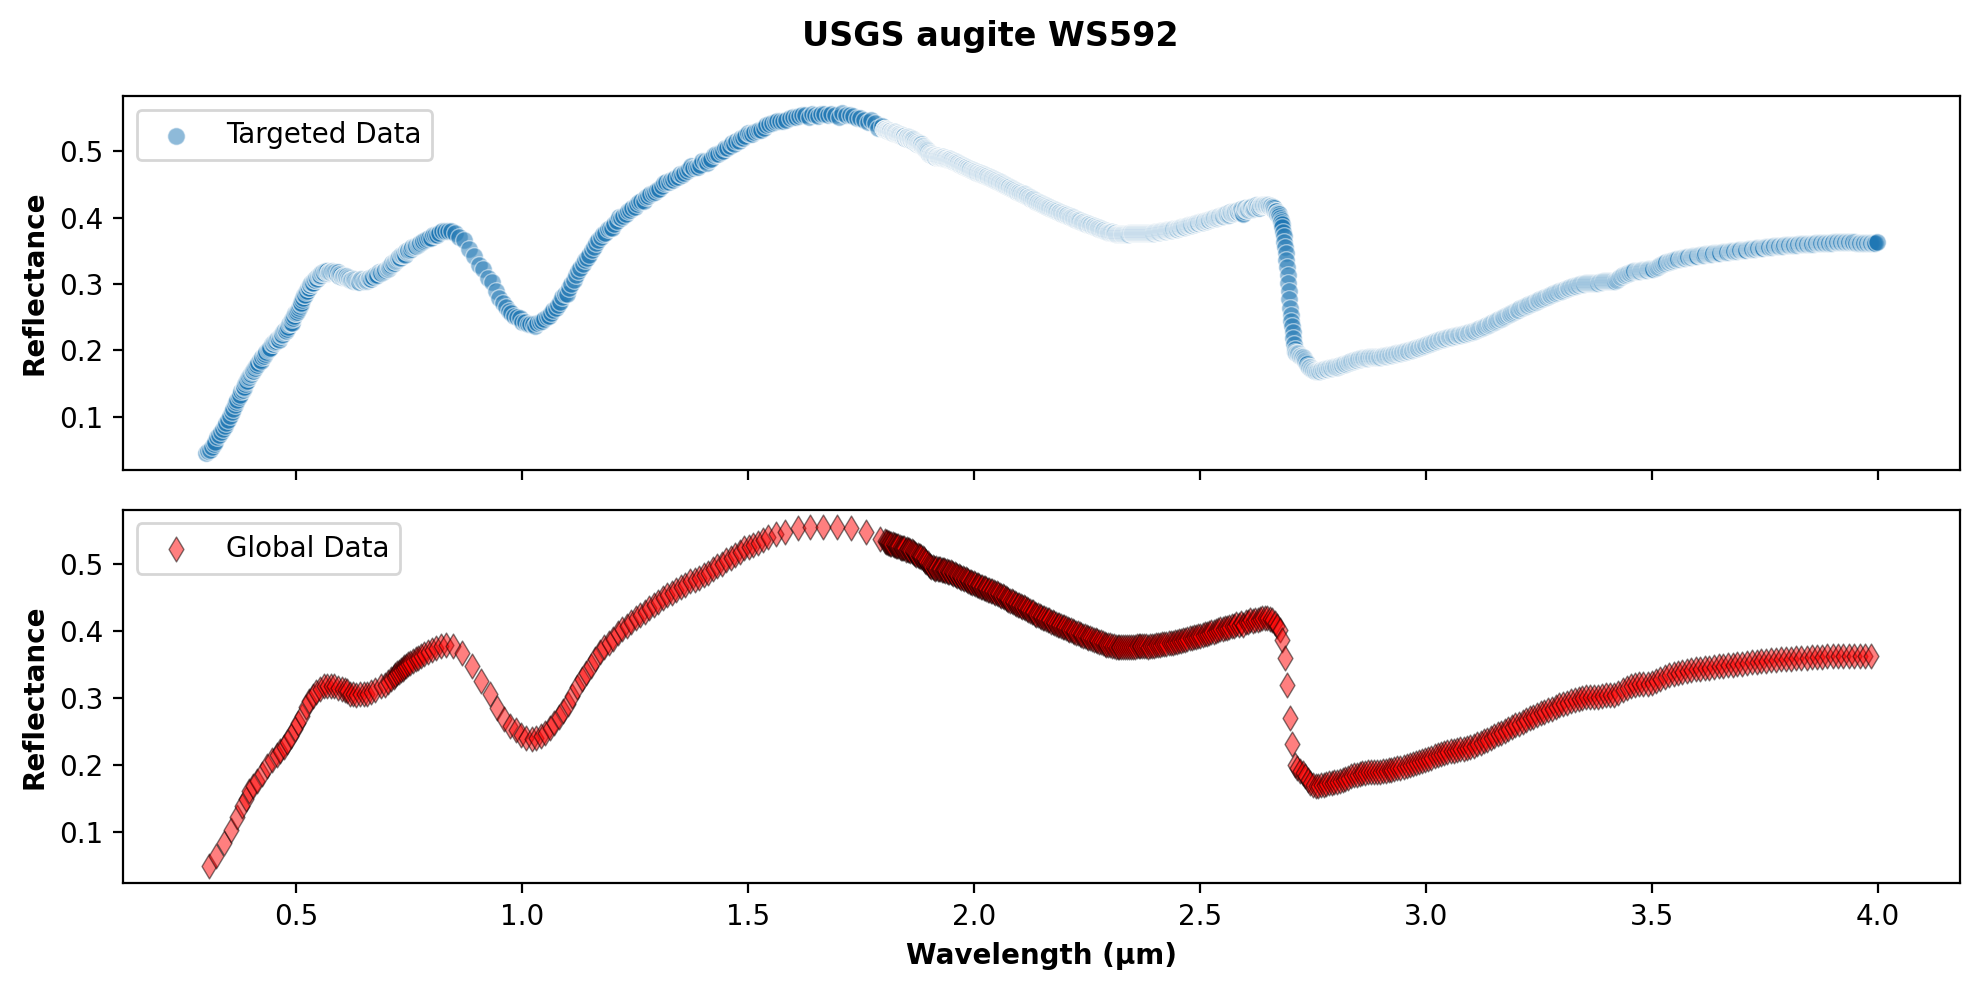

In [19]:
plotting = True
saving = False
if plotting:

    data = {
        "Targeted Data": {'wavelengths':wavelengths, 'values':reflectance},
        "Global Data": targeted_to_global(wavelengths, reflectance)
    }

    colors = ['#1f77b4', "#FF0000"]
    markers = ['o', 'd']
    sizes = [40, 40]
    edgecolors = ['white', 'black']

    fig, axes = plt.subplots(
        nrows = 2,
        sharex=True, 
        figsize=(10, 5), 
        height_ratios=[1,1]
    )

    for ax, (label, contents), color, marker, size, edge in zip(axes, data.items(), colors, markers, sizes, edgecolors):
        sns.scatterplot(
            ax = ax,
            x = contents['wavelengths'],
            y = contents['values'],
            color = color,
            marker = marker,
            edgecolor = edge,
            s = size,
            alpha = 0.5,
            label = label
        )
        ax.set_ylabel("Reflectance", weight='bold')
        ax.legend(loc='upper left')

    # last plot label acts as legend label
    axes[-1].set_xlabel("Wavelength (µm)", weight = 'bold')
    fig.suptitle(f"{data_path.stem}", weight = 'bold')
    plt.tight_layout()
    
    if saving: plt.savefig(
        Path(*[i if i != 'csvs' else 'graphs' for i in list(data_path.parts)]).with_suffix(".png"),
        dpi=2000, 
        bbox_inches='tight',
        facecolor='white'
    )

    plt.show() # calls plt.clf()

In [ ]:
### file writing:
# check if output files/data_path exists
# prompt to create
# write file to output_path

# def guess_output_path(input_path):
#     parts = list(input_path.parts)
#     for i in range(len(parts)-1,-1,-1):
#         if parts[i] == "input files":
#             return Path(*parts[:i]) / "output files"

# def prompt_output_path(input_path):
#     print("Folder 'output files' not found, create one (Y/N)? ")
#     ans = input()
#     while ans.lower() not in ["y", "n", "e"]:
#         ans = input()
#     if ans.lower() != "y":
#         return None

#     print("Enter # to create 'output files' folder in corresponding parent folder.")
#     print("[#] folder name")
#     for c, i in enumerate(output_path.parts):
#         print(f"[{c}] {i}")
#     ans = input()
#     return Path(*list(output_path.parts)[:c]) / "output files"

# def writeFile(df, output_path, mode): 
#     # x - new, w - overwrite
#     df.to_csv(path_or_buf=output_path, index=False, na_rep="")

In [35]:
SEARCH_MSG_OUT = \
    f"> Construct the desired output path by selecting files/folders.\n" \
    f"> Save the path to end search.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit without saving\n" \
    f"[S] Save current path\n" \
    f"[U] Search up one level"

def findOutputFolder(input_path, SEARCH_MSG):
    current_path = Path(input_path)
    if not current_path.exists(): return("Invalid Path")
    
    print(f"Current path: {current_path}")
    print(SEARCH_MSG)
    
    # list out folders with [#] as identifier
    folder_list = [f for f in current_path.iterdir() if f.is_dir()]
    print("> Folders in current folder:")
    if len(folder_list) == 0: print("[#] No folders found.")
    for c, i in enumerate(folder_list):
        print(f"[{c}] {i.name}")
    print("")

    choice = input().lower()
    while choice not in ["e", "s", "u"] + [str(i) for i in range(len(folder_list))]:
        choice = input("Couldn't read input, trying again. Target #: ").lower()

    if choice.lower() == "e": return("Exiting.")
    if choice.lower() == "s": return(current_path)
    if choice.lower() == "u": return(findOutputFolder(current_path.parent, SEARCH_MSG_OUT))
    if choice.isnumeric() and int(choice) in range(len(folder_list)):
        current_path = current_path / folder_list[int(choice)]
        if current_path.is_dir():
            return(findOutputFolder(current_path, SEARCH_MSG_OUT))

    return("Error reading choice, exiting.")

In [ ]:
# print(SEARCH_MSG_OUT)
output_path = findOutputFolder(data_path.parent, SEARCH_MSG_OUT)
print(f"Path selected: {output_path}")

In [29]:
output_dict = targeted_to_global(wavelengths, reflectance, verbose=False)
df_global = pd.DataFrame(output_dict)
df_global = df_global.rename(columns={"wavelengths": "Wavelength (µm) global", "values": f"{df.columns[1]} global"})
df_global = pd.concat((df, df_global), axis = 1)

In [30]:
df_global.head()

,Wavelength (µm),Augite ws592 spliced,Wavelength (µm) global,Augite ws592 spliced global
0,0.3011,0.045344,0.3071,0.0492
1,0.3051,0.047974,0.3231,0.0655
2,0.3091,0.049266,0.3391,0.0835
3,0.3131,0.054325,0.3550,0.1034
4,0.3171,0.058099,0.3681,0.1232


In [31]:
df_global.describe()

,Wavelength (µm),Augite ws592 spliced,Wavelength (µm) global,Augite ws592 spliced global
count,1967.000000,1967.000000,534.000000,534.000000
mean,2.275941,0.363054,2.179465,0.364750
std,0.895307,0.106388,0.917255,0.105177
min,0.301100,0.045344,0.307100,0.049200
25%,1.870520,0.298872,1.644025,0.301450
50%,2.273750,0.377143,2.189750,0.377000
75%,2.898600,0.438936,2.825950,0.441175
max,3.997030,0.557762,3.983200,0.555300


In [32]:
if (output_path/data_path.name).exists():
    print(f"File path already exists, overwrite (Y/N)?")
    ans = input()
    while ans.lower() not in ["y", "n"]:
        ans = input()
    if ans.lower() == "y":
        df_global.to_csv(path_or_buf = output_path/data_path.name, index = False, na_rep = "")
else:
    df_global.to_csv(path_or_buf = output_path/data_path.name, index = False, na_rep = "")

File path already exists, overwrite (Y/N)?
